In [1]:
import squidward.gpr as gpr
import squidward.kernels as kernels
import squidward.gp_viz as gp_viz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Hierarchical 1D Regression

In [2]:
data_size = 1000

bids = auction = np.concatenate([
    np.linspace(0,50,data_size),
    np.linspace(0,50,data_size),
    np.linspace(0,50,data_size)
    ])

auction = np.concatenate([
    0.0*np.ones(data_size),
    1.0*np.ones(data_size),
    2.0*np.ones(data_size)
    ])

profit = np.ones(3*data_size)
profit[:data_size] = 2.3*bids[:data_size]+25*np.sin(.2*bids[:data_size])
profit[data_size:2*data_size] = 2.3*bids[data_size:2*data_size]+25*np.sin(.2*bids[data_size:2*data_size])-30
profit[-data_size:] = 2.3*bids[-data_size:]+25*np.sin(.2*bids[data_size:2*data_size])+50

In [3]:
sample_size = 15

indx = np.random.randint(0,3*data_size-1,sample_size)
bids_train = bids[indx]
auction_train = auction[indx]
profit_train = profit[indx] + np.random.normal(0,7,sample_size)

def one_hot(a, num_classes):
    a = a.astype(np.int32)
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

auction_train_one_hot = one_hot(auction_train,3)

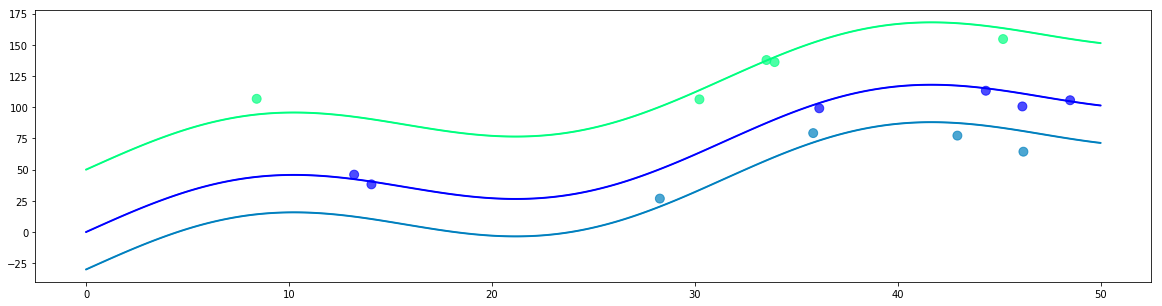

In [4]:
plt.figure(figsize=(20,5))
plt.scatter(bids,profit,c=auction,s=1, cmap='winter')
plt.scatter(bids_train,profit_train,c=auction_train,s=80,alpha=.7, cmap='winter')
plt.show()

In [5]:
x = np.concatenate([bids_train.reshape(-1,1), auction_train.reshape(-1,1)], axis=1)
y = profit_train

means, vars = [], []
kernel = kernels.rbf(100**2,15.0)
for i in range(3):
    ind = ((i == x)).nonzero()[0]
    y_ = y[ind]
    x_ = x[ind,0]
    model = gpr.gaussian_process(kernel=kernel,var_l=5.0**2,inv_method='solve')
    model.fit(x_,y_)
    x_test = np.linspace(0,50,100)
    mean, var = model.posterior_predict(x_test)
    means.append(mean)
    vars.append(vars)

/anaconda3/envs/base_env/lib/python3.6/site-packages/squidward/gpr.py:43: UserWarning: Covariance of low rank. Matrix might not be invertible.
  warnings.warn('Covariance of low rank. Matrix might not be invertible.')


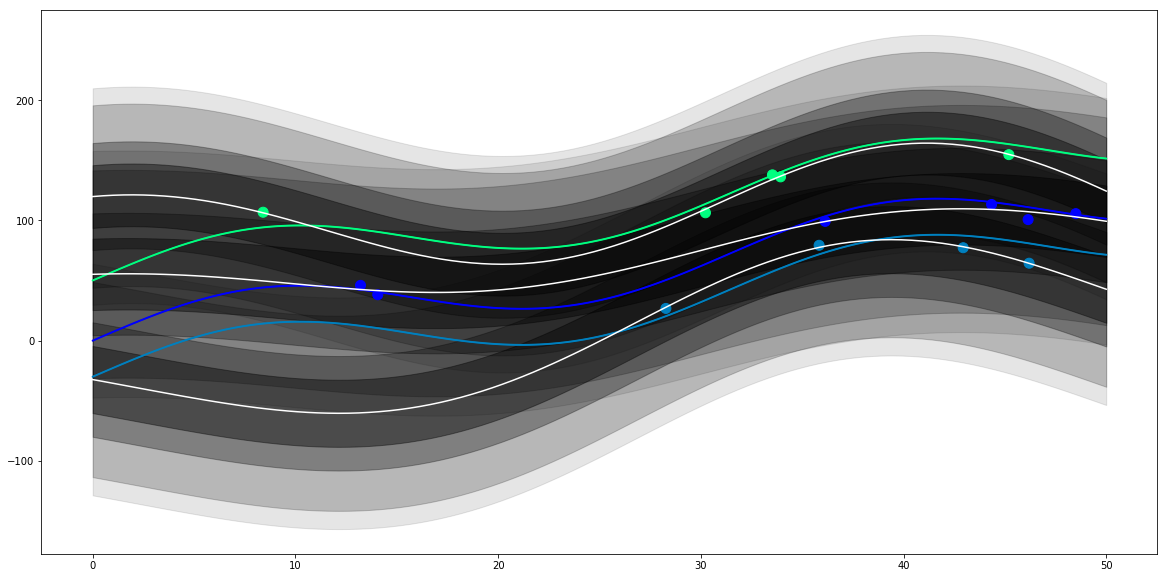

In [6]:
plt.figure(figsize=(20,10))
for i in range(3):
    gp_viz.regression.plot_1d(x_test,means[i],var[i])
plt.scatter(bids,profit,c=auction,cmap='winter',s=1)
plt.scatter(bids_train,profit_train,c=auction_train,cmap='winter',s=100)
plt.show()

In [7]:
class hierarchical_rbf(object):
    def __init__(self,var_k,l):
        self.var_k = var_k
        self.l = l

    def _k(self,a,b):
        a = a.reshape(-1,1)
        b = b.reshape(-1,1)
        z = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) -2.0*a.dot(b.T)
        alpha = (1.0/(self.l**2))
        return self.var_k * np.exp(-0.5*alpha*z)

    def k(self,a,b):
        outputs = []
        for i in range(a.shape[1]):
            outputs.append( self._k(a[:,i],b[:,i]) )
        return outputs[0] + outputs[1]*outputs[2]*outputs[3]

In [8]:
x = np.concatenate([bids_train.reshape(-1,1), auction_train_one_hot], axis=1)

kernel = hierarchical_rbf(25**2,10.0)
model = gpr.gaussian_process(kernel=kernel,var_l=5.0**2,inv_method='cholesky')
model.fit(x,y)

x_test = np.concatenate([bids.reshape(-1,1), one_hot(auction,3)], axis=1)
mean, var = model.posterior_predict(x_test)

/anaconda3/envs/base_env/lib/python3.6/site-packages/squidward/gpr.py:43: UserWarning: Covariance of low rank. Matrix might not be invertible.
  warnings.warn('Covariance of low rank. Matrix might not be invertible.')


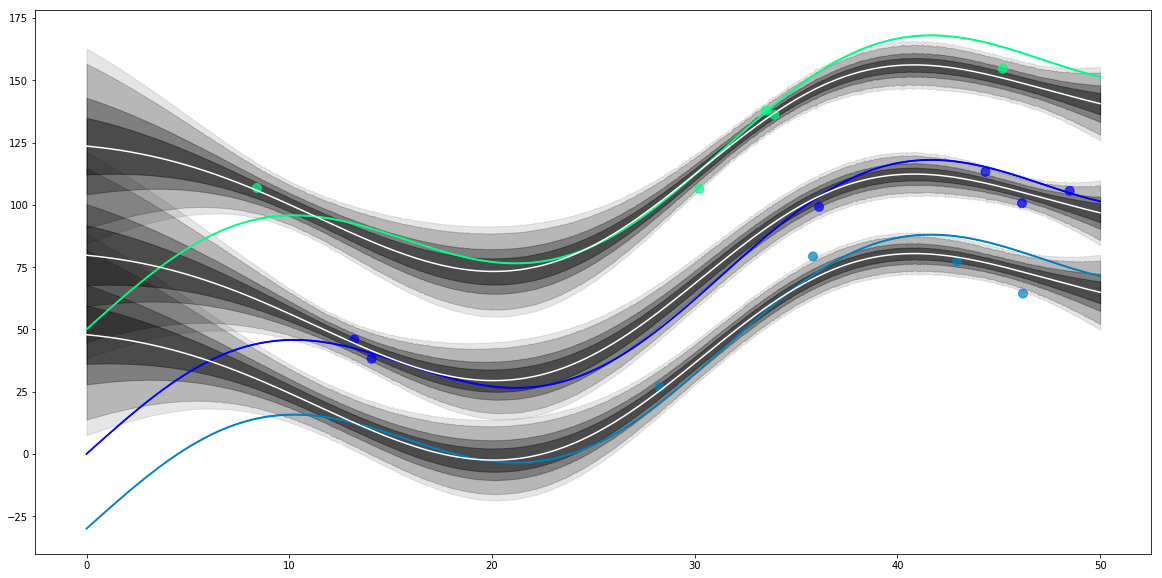

In [9]:
plt.figure(figsize=(20,10))
gp_viz.regression.plot_1d(x_test[:data_size,0],mean[:data_size],var[:data_size,0])
gp_viz.regression.plot_1d(x_test[data_size:-data_size,0],mean[data_size:-data_size],var[data_size:-data_size,0])
gp_viz.regression.plot_1d(x_test[-data_size:,0],mean[-data_size:],var[-data_size:,0])
plt.scatter(bids,profit,c=auction,s=1, cmap='winter')
plt.scatter(bids_train,profit_train,c=auction_train,s=80,alpha=.7, cmap='winter')
plt.show()

In [10]:
class hierarchical_rbf2(object):
    def __init__(self,var_k,l,hvar_k,hl):
        self.var_k = var_k
        self.l = l
        self.hvar_k = hvar_k
        self.hl = hl

    def _k(self,a,b):
        a = a.reshape(-1,1)
        b = b.reshape(-1,1)
        z = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) -2.0*a.dot(b.T)
        alpha = (1.0/(self.l**2))
        return self.var_k * np.exp(-0.5*alpha*z)
    
    def _hk(self,a,b):
        a = a.reshape(-1,1)
        b = b.reshape(-1,1)
        z = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) -2.0*a.dot(b.T)
        alpha = (1.0/(self.hl**2))
        return self.hvar_k * np.exp(-0.5*alpha*z)

    def k(self,a,b):
        outputs = []
        for i in range(a.shape[1]): 
            if i == 0:
                outputs.append( self._k(a[:,i],b[:,i]) )
            else:
                outputs.append( self._hk(a[:,i],b[:,i]) )
        return outputs[0]*outputs[1]*outputs[2]*outputs[3]

In [11]:
x = np.concatenate([bids_train.reshape(-1,1), auction_train_one_hot], axis=1)

kernel = hierarchical_rbf2(5**2,10.0,2**2,1.0)
model = gpr.gaussian_process(kernel=kernel,var_l=5**2,inv_method='cholesky')
model.fit(x,y)

x_test = np.concatenate([bids.reshape(-1,1), one_hot(auction,3)], axis=1)
mean, var = model.posterior_predict(x_test)

/anaconda3/envs/base_env/lib/python3.6/site-packages/squidward/gpr.py:43: UserWarning: Covariance of low rank. Matrix might not be invertible.
  warnings.warn('Covariance of low rank. Matrix might not be invertible.')


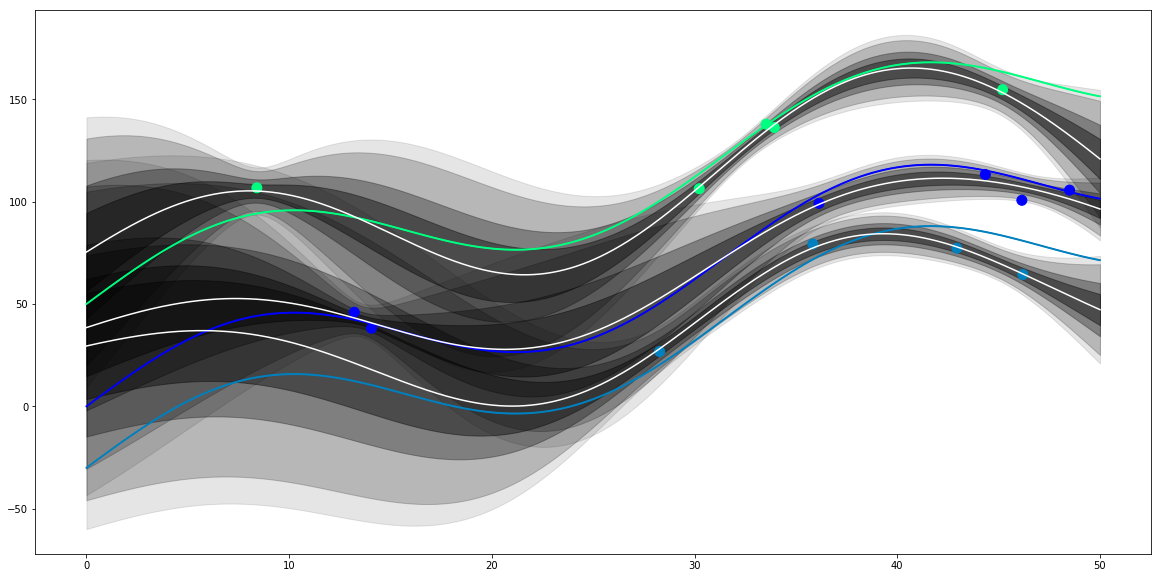

In [12]:
plt.figure(figsize=(20,10))
gp_viz.regression.plot_1d(x_test[:data_size,0],mean[:data_size],var[:data_size,0])
gp_viz.regression.plot_1d(x_test[data_size:-data_size,0],mean[data_size:-data_size],var[data_size:-data_size,0])
gp_viz.regression.plot_1d(x_test[-data_size:,0],mean[-data_size:],var[-data_size:,0])
plt.scatter(bids,profit,c=auction,s=1, cmap='winter')
plt.scatter(bids_train,profit_train,c=auction_train,s=100, cmap='winter')
plt.show()